In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal

import sys
sys.path.insert(0,'..')
import specsens as ss

In [2]:
sample_freq = 1e6  # in Hz
length = 1.0  # in s
signal_strength = 0.0  # in dB
noise_strength = 5.0  # in dB

wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length)
sig = wm.get_soft(f_center=1e5, power=signal_strength, dB=True)

wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.get_signal(power=noise_strength, dB=True)

assert wm.num_samples == wgn.num_samples  # ensure noise and signal have same length
num_samples = wm.num_samples

both = sig + noise  # create actual signal ('both') comprising of signal and additive white gaussian noise (AWGN)

print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num Samples:  %d ' % (num_samples))

# Note, that Parseval's theorem holds
from scipy import fft
print("Freq Energy:  %.2f" % (np.sum(np.abs(fft.fft(both))**2)/sample_freq))
print("Time Energy:  %.2f" % (np.sum(np.abs(both)**2)))

Signal power: 0.00 dB
Noise power:  5.01 dB
SNR:          -5.01 dB
Num Samples:  1000000 
Freq Energy:  4168165.35
Time Energy:  4168165.35


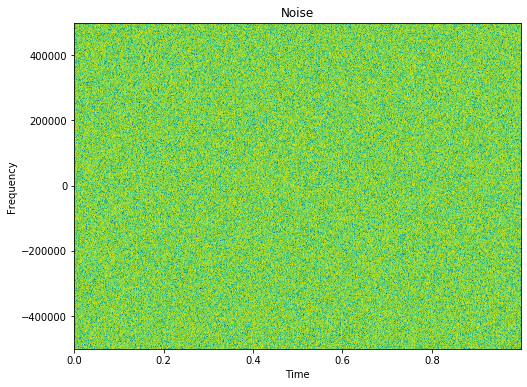

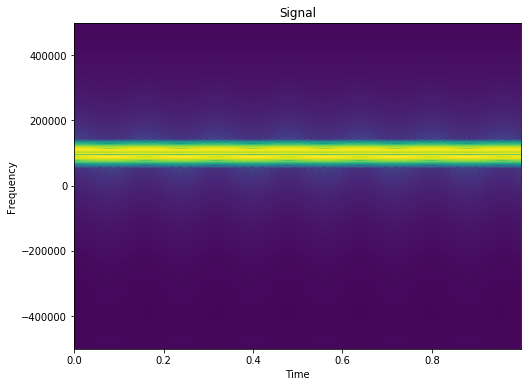

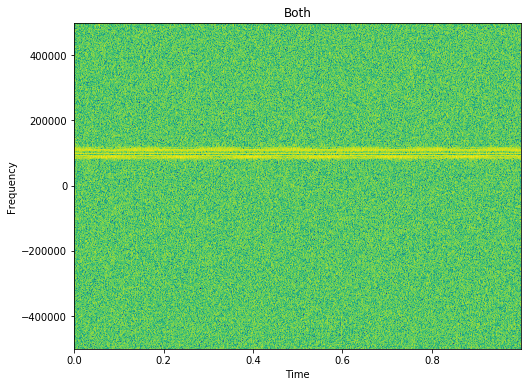

In [4]:
# Plot the spectogram our Short Time Fourier Transform
nfft = 1024

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(noise, sample_freq, normalized=True, dB=True)
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Noise")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(sig, sample_freq, normalized=True, dB=True)
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Signal")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)

plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Both")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

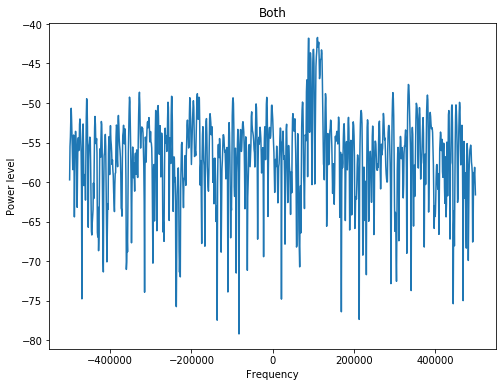

In [4]:
# Plot only 2nd FFT bin using our Short Time Fourier Transform

sft = ss.Stft(n=1024, window='flattop')
f, x = sft.stft(both[1024:2048], sample_freq, normalized=True, dB=True)

plt.figure(figsize=(8, 6))
plt.plot(f, x)
plt.title("Both")
plt.xlabel("Frequency")
plt.ylabel("Power level")
plt.show()

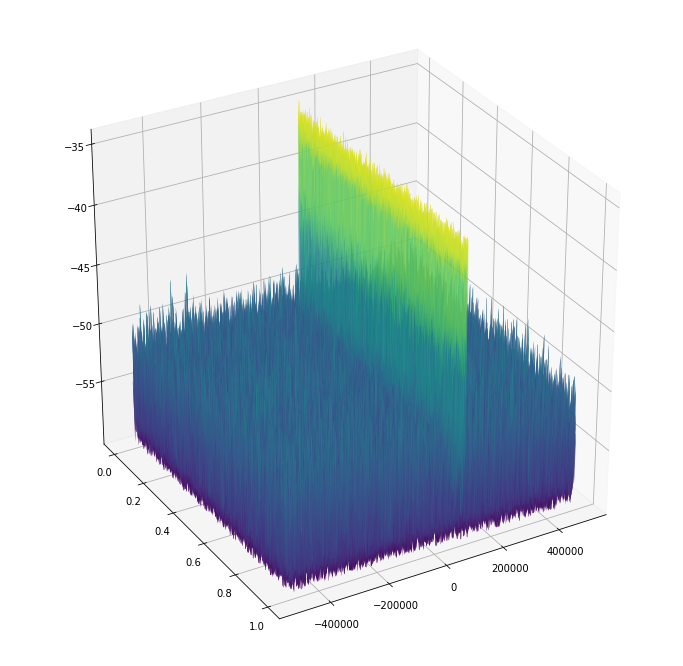

In [18]:
# Use out 3D Plot 
ss.plot3d(sig=both,
          f_sample=sample_freq,
          window='flattop',
          nfft=1024,
          clip=-60,
          smooth=.5,
          crop=None,
          elev=30,
          azim=60,
          type='our')